# 딥러닝으로 NSMC 분석하기

# 필요 함수 만들기

In [1]:
# 데이터 불러오기
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("ratings_train.txt")
test_docs = read_documents("ratings_test.txt")

In [2]:
# MeCab 함수 설정

"""
    Parsing 규칙의 문제점, split을 "," 기준으로 하는데, token이 "," 인 경우에는 쉼표만 잘려서 나오기 때문에, 
    + "%," 같이 특수문자와 쉼표가 같이 등장하는 경우도 생각해주어야 함.
    
    (",", "SC") 의 원래 튜플이 만들어지지 않음.
    
    명사 분석의 경우 해당 토큰이 필요하지 않으니 pass
    
    형태소 분석과 POS tagging의 경우 해당 토큰이 필요하므로, token[0]이 ' 인 경우엔 따로 (",", "SC")를 집어 넣어줘야함.
"""
import MeCab # 윈도우 명령어
import re

mecab = MeCab.Tagger()

def mecab_nouns(text):
    nouns = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 POS가 명사 분류에 속하는 토큰만 선택.
    for token in temp:
        if token[1] == "NNG" or token[1] == "NNP" or token[1] == "NNB" or token[1] == "NNBC" or token[1] == "NP" or token[1] == "NR":
            nouns.append(token[0])
        
    return nouns

def mecab_morphs(text):
    morphs = []
    
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    # 추출한 token중에 문자열만 선택.
    for token in temp:
        morphs.append(token[0])
    
    return morphs

def mecab_pos(text):
    pos = []
    # 우리가 원하는 TOKEN\tPOS의 형태를 추출하는 정규표현식.
    pattern = re.compile(".*\t[A-Z]+") 
    
    # 패턴에 맞는 문자열을 추출하여 konlpy의 mecab 결과와 같아지도록 수정.
    pos = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    return pos

In [3]:
# 텍스트 클리닝 함수

def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
        
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab_morphs(doc) if word not in SW and len(word) > 1]
    
    # wordcloud를 위해 명사만 추출하는 경우.
    #return [word for word in mecab_nouns(doc) if word not in SW and len(word) > 1]

* 불러온 데이터를 품사 태그를 붙여서 토크나이징

In [4]:
import MeCab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint

#okt = Okt()
mecab = MeCab.Tagger()

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(line[1])]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(line[1])]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['GDNTOPCLASSINTHECLUB'], '0']


In [5]:
print(train_data[:3])

[[['진짜', '짜증', '네요', '목소리'], '0'], [['..', '포스터', '보고', '초딩', '영화', '...', '오버', '연기', '조차', '가볍', '구나'], '1'], [['너무', '밓었다그래서보는것을추천한다'], '0']]


* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 전처리를 합니다.

## Deep Neural Network로 분류하기

In [6]:
# 필요한 라이브러리 불러오기
import numpy as np 
import tensorflow as tf

# tf관련 대부분의 함수는 keras에 있다.
from tensorflow.keras.preprocessing.text import Tokenizer # 토큰화

# network 구성
#from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN, GRU 
from tensorflow.keras.layers import Embedding, Dense, LSTM # layer 3개 

# keras model 생성시 Sequntial object를 만들고 하나씩 layer를 추가할 때 사용
from tensorflow.keras.models import Sequential

# RNN, LSTM의 구조와 다르게 text는 길이가 제각각
# 텍스트 최대길이를 설정해서 길이를 분류하는데
# 최대길이보다 짧은 텍스트들이 있을때 나머지를 자동으로 채워주는 모듈
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [7]:
# GPU 분석환경인지 확인하기
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5243036912873149321,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1980026062
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 928409579531519129
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## Set Hyperparameter 

In [8]:
max_words = 35000 # feature selection에 사용 (불필요 데이터 drop)
max_len = 30 # network(=문서)의 최대 길이 (여기서는 리뷰 1개)
batch_size = 128 # 보통 32배수(Nvidia GPU연산단위 ), 커질수록 GPU utilization이 올라간다.
EPOCHS = 20 # 학습 횟수 (높을수록 결과가 잘나옴. 단 overfitting은 주의) 

## Define Network Structure 

In [9]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self):
        super().__init__() # keras 모델의 init load (네트워크 구조 구성)
        # 1번째 layer
        # LSTM의 각 노드가 128차원
        # max_words만큼의 텍스트를 가질 수 있다.
        self.emb = Embedding(max_words, 100) # tf.keras.layers import Embedding
        # 2번째 layer
        # lstm 불러오기
        # dropout : overfitting 가능성을 줄여줌 (regulazation 방식)
        self.lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2) #tf.keras.layers import LSTM
        # 3번째 layer (최종결과 내기)
        # 결과값은 0, 1 이므로 1개
        self.dense = Dense(1, activation="sigmoid")
    
    def __call__(self, x, training=None, mask=None):
        x = self.emb(x) # embedding에 text넣기
        x = self.lstm(x) # lstm에 넣기
        return self.dense(x) # 결과 return

## Data Preprocessing 

In [10]:
# SVM 때와 비슷한 형태로 데이터 불러오기
# keras맞춤형 Tokenizing하기위한 기준이 되는 데이터
x_train = [doc for doc, _ in train_data]

# keras가 사용하기 위한 형태로 Tokenizing
# 여기 까지는 '단어' 로 존재
tokenizer = Tokenizer(num_words=max_words) # 최대 35000개 단어(feature) 사용
tokenizer.fit_on_texts(x_train) # 반드시 fit을 해줘야 한다.


# LSTM의 input으로 넣기 위한 변환 작업
# x_train, x_test, y_train, y_test 변환하기
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences([doc for doc, _ in test_data])

# label값
# texts_to_sequences한 값은 numpy 형태 = 통일 시켜줘야 한다. (np.int64)
y_train = np.array([int(label) for _, label in train_data])
y_test = np.array([int(label) for _, label in test_data])

print(x_train[0]) # 결과 확인

# 크기를 맞춰주기 위한 zero padding
# pad_sequences 활용
# value = 0 : 패딩할때 0으로 채워라 (default이긴 함)
# padding ='pre' : 앞 부터 채워라
x_train = pad_sequences(x_train, value=0, padding='pre', maxlen=max_len)
x_test = pad_sequences(x_test, value=0, padding='pre', maxlen=max_len)
print("\n", x_train[0]) # 결과 확인

# 학습 가능한 형태로 최종 변환.
# 10000개씩 shuffle (training 되는 순서 자체로 인해 overfitting 될 가능성 있기 때문)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
# test는 shuffle이 필요없으므로 skip
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[10, 116, 7, 480]

 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  10 116   7 480]


#토큰을 숫자로으로 변경


[10, 116, 7, 480]

#제로 패딩 결과


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  10 116   7 480]

## Set Model 

In [11]:
# 모델 선언
model = SimpleLSTM()

# 모델 컴파일 : 바로 모델 사용 가능
# optimizer : 보통은 adam (가장 성능이 좋음)
    # RMSProp, SGD 등
# loss : label이 어떤 것인지, layer을 어떻게 설정했는지에 따라 다르게 설정 해줘야 함
    # 현재 구조 : dense layer, 결과값은 1개만 나오도록, 결과 추출은 sigmoid로 = binary_crossentropy 
    # 0, 1로 구분할 경우에는 binary_crossentropy를 사용
# metrics : 평가 방법

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Early Stopping Callback
---
- overfitting 하면서 validation loss가 점점 하강곡선을 그려야 하는데, 다시 상승 하는 경우가 있다. 
- 이 경우 다시 overfitting이 되고 있다는 것 
- 간혹 validation loss가 올라가도 학습이 잘되는 경우도 있기는 함 (이 경우는 보통 일시적으로 상승하다가 다시 하강함)
- 즉, 지속적으로 다시 상승곡선을 그린다면 overfitting이 확실하다. 이 경우 멈추 도록 옵션을 지정하는 것

In [12]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)

## Run Model 

In [13]:
# 실행, 결과 저장 (to visualize)
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[earlystopper])

Epoch 1/20
1157/1157 [==============================] - 375s 321ms/step - loss: 0.4101 - accuracy: 0.8089 - val_loss: 0.3809 - val_accuracy: 0.8254
Epoch 2/20
1157/1157 [==============================] - 342s 296ms/step - loss: 0.3251 - accuracy: 0.8576 - val_loss: 0.3898 - val_accuracy: 0.8275
Epoch 3/20
1157/1157 [==============================] - 339s 293ms/step - loss: 0.2716 - accuracy: 0.8822 - val_loss: 0.4457 - val_accuracy: 0.8217
Epoch 4/20
1157/1157 [==============================] - 339s 293ms/step - loss: 0.2205 - accuracy: 0.9064 - val_loss: 0.4967 - val_accuracy: 0.8154
Epoch 5/20
1157/1157 [==============================] - 343s 296ms/step - loss: 0.1821 - accuracy: 0.9236 - val_loss: 0.5880 - val_accuracy: 0.8118
Epoch 6/20
1157/1157 [==============================] - 340s 294ms/step - loss: 0.1560 - accuracy: 0.9342 - val_loss: 0.6716 - val_accuracy: 0.8130
Epoch 7/20
1157/1157 [==============================] - 338s 292ms/step - loss: 0.1373 - accuracy: 0.9425 - val_

- 진행상황을 보면 Epoch가 올라가면서 loss값이 감소/ accuracy는 증가하는 것을 확인할 수 있다. (정상)
- 만약 초반 Epoch부터 loss가 올라가고, accuracy가 안올라가면 overfitting이 되고 있는 것. (모델이 잘못 짜여진 것)
---
- 만약 실행중 에러가 나는데 그 내용이 'OOM(Out of Memory)' 이라면, 메모리 부족으로 발생한 것
- 이 경우 kernel restart를 해주면 된다.

In [14]:
# Model Test
score, acc = model.evaluate(x_test,y_test, batch_size=batch_size)

386/386 [==============================] - 12s 31ms/step - loss: 1.0219 - accuracy: 0.8057


In [15]:
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  1.0219436883926392
Test Accuracy:  0.8056889176368713


## Loss Visualization 

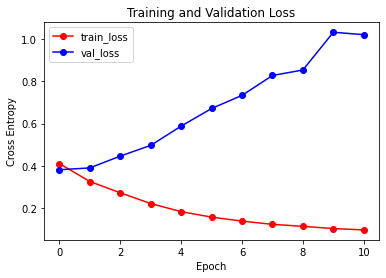

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label="train_loss")
plt.plot(val_loss, 'bo-', label="val_loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

- validation loss는 증가 , train_loss는 감소하는 모양세
- validation loss는 증가 = overfitting 되고 있다.
- 현재는 Epoch가 너무 짧아서 증가하다가 다시 감소하는 건지, 계속 증가하는 건지 파|악이 어렵다. (15~30정도로 돌려보면 안정적이게 나옴)

## Save Weight 

In [17]:
# Model weight matrix 저장.
model.save_weights("nsmc_keras_simplelstm") # ()안에 저장명 자유롭게 지정

# 추후 load 할 경우
# model.load_weights("nsmc_keras_simplelstm")